In [2]:
import os
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import optimize
from scipy.signal import find_peaks, peak_widths, savgol_filter, convolve, peak_prominences
from scipy.fft import *
# from scipy.fftpack import *
import peakutils
from peakutils.plot import plot as pplot

In [3]:
folder ='Affinity Data/AAV10'
CSVs = glob.glob(f'{folder}/*.csv')


In [4]:
CSVs[4]

'Affinity Data/AAV10/AAVW3_AAV10 HEK lysate 003.csv'

In [5]:
bl = pd.read_csv(CSVs[12], delimiter='\t', encoding='utf_16', skiprows=[0,1], low_memory=False)
bl = bl['mAU']
# bl.fillna(0, inplace=True)

In [6]:
data = pd.read_csv(CSVs[4], delimiter='\t', encoding='utf_16', skiprows=[0,1], low_memory=False)

In [13]:
data[['Logbook', 'ml.5']].head(10)

,Logbook,ml.5
0,Method Settings,-0.001026
1,Equilibration,12.002364
2,Sample Application,12.008546
3,Column Wash,22.003009
4,Elution,22.012950
5,Column CIP,23.213656
6,NaN,24.413623
7,NaN,25.613696
8,NaN,26.813693
9,NaN,28.013419


In [11]:
data.columns

Index(['ml', 'mAU', 'ml.1', 'mS/cm', 'ml.2', '%', 'ml.3', 'Injection', 'ml.4',
       'Logbook', 'ml.5', 'Fraction', 'ml.6', 'mAU.1', 'ml.7', 'mAU.2', 'ml.8',
       'pH', 'ml.9', 'MPa', 'ml.10', 'MPa.1', 'ml.11', 'MPa.2', 'ml.12',
       'MPa.3', 'ml.13', 'MPa.4', 'ml.14', 'ml/min', 'ml.15', 'cm/h', 'ml.16',
       'ml/min.1', 'ml.17', 'cm/h.1', 'ml.18', 'cm', 'ml.19', 'CV/h', 'ml.20',
       'CV/h.1', 'ml.21', '%.1', 'ml.22', '°C', 'ml.23', '°C.1'],
      dtype='object')

In [7]:
data['mAU'] = data['mAU'].apply(lambda x: 0 if x < 0 else x)
data['mAU'] = data['mAU'].loc[data['ml'] > 0]
data['mAU'] = data['mAU'].loc[data['ml'] > 20]
data['mAU'].reset_index(drop=True, inplace=True)
data['mAU'].dropna(inplace=True)


In [1]:
indexes = peakutils.indexes(data['mAU'], thres=0.1, min_dist=6500)
# print(indexes)
# print(data['ml'][indexes], data['mAU'][indexes])
plt.figure(figsize=(10,6))
pplot(data['ml'], data['mAU'], indexes)
plt.title('First estimate')

NameError: name 'peakutils' is not defined

In [37]:
peaks_x = peakutils.interpolate(data['ml'].values, data['mAU'].values, ind=indexes)
print(peaks_x)

[23.09719972 40.31968813]


In [47]:
peaks

array([27166, 39547, 41292])

In [51]:
results_five_pec[1:]

(array([ 7.87403565, 14.00685475,  8.24897285]),
 array([26916.72653058, 38491.33216463, 38126.46264507]),
 array([28042.9178098 , 40599.62645573, 42863.21867373]))

In [54]:
peaks

array([27166, 39547, 41292])

In [69]:
a = peaks[0] - results_five_pec[1:][1][0]
b = results_five_pec[1:][2][0] - peaks[0]


#Tailing factor
Tf = (a+b)/ (2 *a)
S = b / (2 * a)

print(Tf)
print(S)

2.2589473357301824
1.7589473357301824


In [72]:
data['ml'][peaks[0]]

23.097897

In [35]:
def tailing_factor(peaks, results, height):
    res = {}
    for i in range(len(peaks)):
        a = peaks[i] - results[1][i]
        b = results[2][i] - peaks[i]
        Tf = (a+b) / (2*a)
        res[height[i]] = Tf
    return res

def symmmetry_factor(peaks, results, height):
    res = {}
    for i in range(len(peaks)):
        a = peaks[i] - results[1][i]
        b = results[2][i] - peaks[i]
        S = b / (2 * a)
        res[height[i]] = S
    return res


def peak_assymetry(peaks, results, height):
    res = {}
    for i in range(len(peaks)):
        a = peaks[i] - results[1][i]
        b = results[2][i] - peaks[i]
        res[height[i]] = b/a
    return res

def number_of_theoretical_plates(peaks, results, height):
    res = {}
    for i in range(len(peaks)):
        retention_volume = data['ml'][peaks[i]]

        width = results[i]
        N = 5.54 * (retention_volume/width)**2
        res[height[i]] = N
    return res


def area(peaks, results, height):
    res = {}
    n_plates = number_of_theoretical_plates(peaks, results, height)
    for i in range(len(peaks)):
        retention_time = peaks[i]
        H = height[i]
        N = n_plates[H]
        denominator = math.sqrt(N / (2*math.pi))
        print(data['ml'][retention_time])
        area = (retention_time * H) / denominator
        res[height[i]] = area
    return res

In [48]:
print(data['ml'][27058])
print(data['ml'][27306])
print(data['ml'][27306] - data['ml'][27058])

22.966198
23.268616
0.30241800000000296


In [46]:
round(27305.67544314)

27306

In [37]:
results_half

(array([247.26964697, 980.60128396, 559.77882944]),
 array([78.7403565, 36.0413725, 69.0671555]),
 array([27058.40579616, 38772.17753512, 41137.59803909]),
 array([27305.67544314, 39752.77881908, 41697.37686853]))

In [92]:
peaks

array([27166, 39547, 41292])

In [91]:
results_half[0]

array([247.26964697, 980.60128396, 559.77882944])

In [74]:
results_five_pec[1:][1]

array([26916.72653058, 38491.33216463, 38126.46264507])

In [36]:
print(tailing_factor(peaks, results_five_pec[1:], prominences))
print(symmmetry_factor(peaks, results_five_pec[1:], prominences))
print(peak_assymetry(peaks, results_ten_pec[1:], prominences))
print(number_of_theoretical_plates(peaks, results_half[0], prominences))
print(area(peaks, results_half[0], prominences))

{157.480713: 2.2589473357301824, 48.965595: 0.9985594997156104, 135.15151699999998: 0.7481756645970223}
{157.480713: 1.7589473357301824, 48.965595: 0.4985594997156104, 135.15151699999998: 0.24817566459702234}
{157.480713: 2.5829629224071, 48.965595: 0.6972771501382411, 135.15151699999998: 4.26796375486945}
{157.480713: 0.048340710345702226, 48.965595: 0.008405236367398941, 135.15151699999998: 0.02874693196105486}
23.097897
38.19553
40.323418
{157.480713: 48773788.310163684, 48.965595: 52944341.21489006, 135.15151699999998: 82505144.08698143}


In [53]:
prominences

array([157.480713,  48.965595, 135.151517])

In [9]:
results_full

(array([2242.        , 2472.14163342, 7616.77992685]),
 array([ 0.      , 11.558575,  1.491397]),
 array([26877.        , 38389.85836658, 37124.22007315]),
 array([29119., 40862., 44741.]))

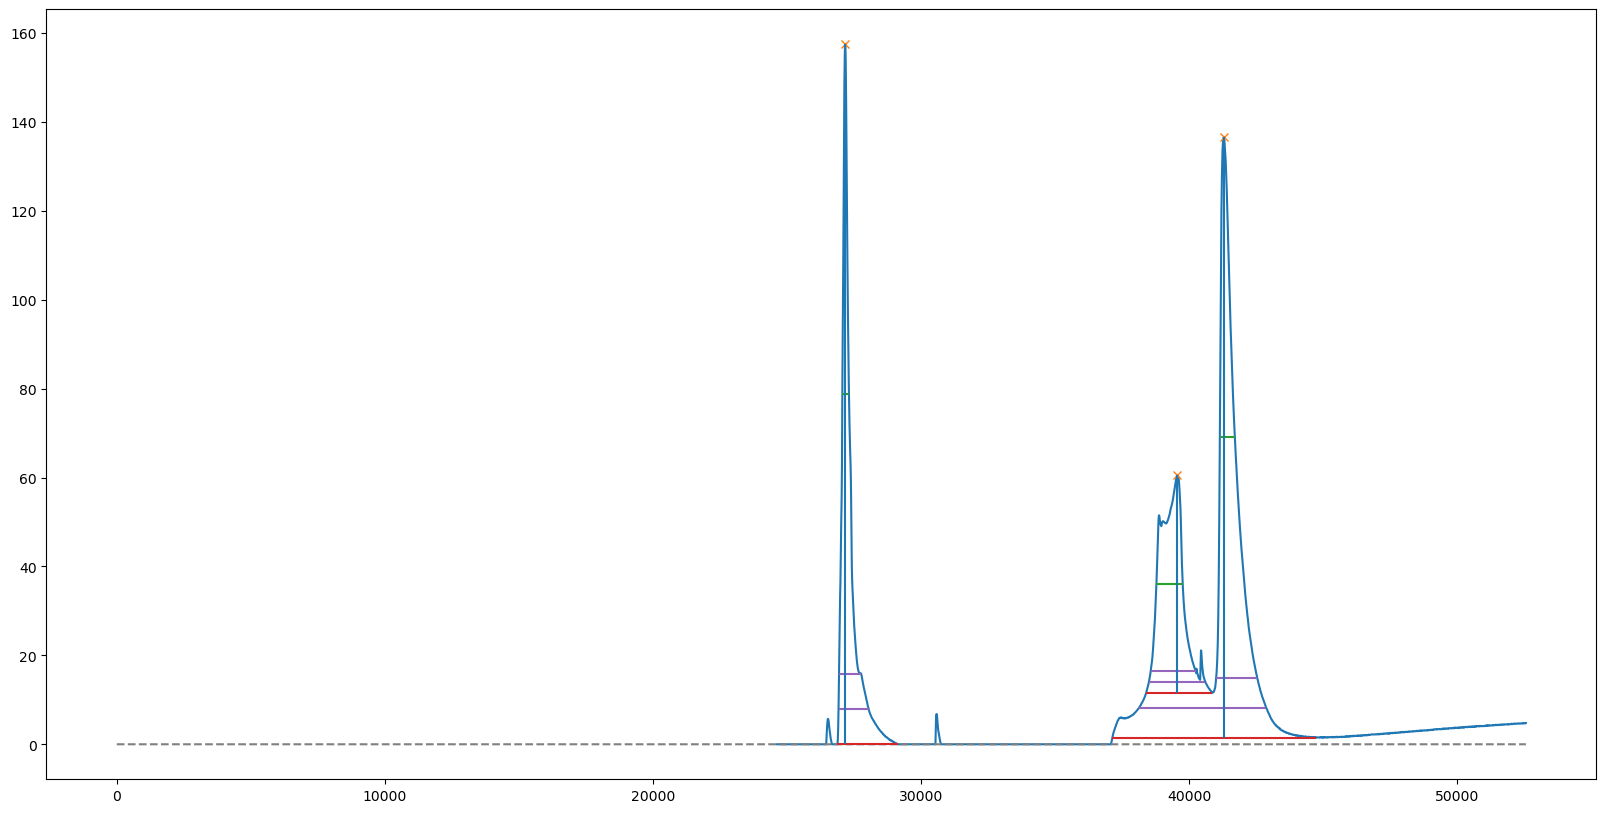

In [8]:
peaks, info = find_peaks(data['mAU'], height=60, width=65)
results_half = peak_widths(data['mAU'], peaks, rel_height=0.5)
results_full = peak_widths(data['mAU'], peaks, rel_height=1)
results_five_pec = peak_widths(data['mAU'], peaks, rel_height=0.95)
results_ten_pec = peak_widths(data['mAU'], peaks, rel_height=0.9)
prominences = peak_prominences(data['mAU'], peaks)[0]
contour_heights = data['mAU'][peaks] - prominences

# sgf = savgol_filter(data['mAU'][peaks], 4, 1)
# plt.plot(peaks, sgf, c = 'orange', linewidth=3)
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(data['mAU'])
plt.plot(peaks, data['mAU'][peaks], "x")
plt.plot(np.zeros_like(data['mAU']), "--", color="gray")
plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C3")
plt.hlines(*results_five_pec[1:], color="C4")
plt.hlines(*results_ten_pec[1:], color="C4")
plt.vlines(x=peaks, ymin=contour_heights, ymax=data['mAU'][peaks])
plt.show()

In [15]:
print(len(bl))
print(len(data['mAU']))
bl = bl.reindex(range(len(data['mAU'])), fill_value=0)
print(len(bl))
print(len(data['mAU']))

NameError: name 'bl' is not defined

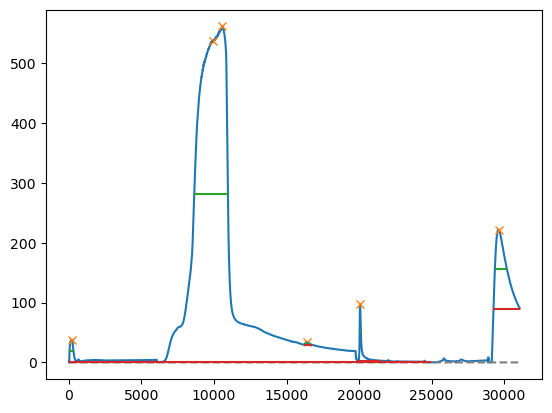

In [152]:
bl_rem = data['mAU'] - bl
peaks, info = find_peaks(bl_rem, height=30, width=50)
results_half = peak_widths(bl_rem, peaks, rel_height=0.5)
results_full = peak_widths(bl_rem, peaks, rel_height=1)
# sgf = savgol_filter(data['mAU'][peaks], 4, 1)
# plt.plot(peaks, sgf, c = 'orange', linewidth=3)
plt.plot(bl_rem)
plt.plot(peaks, bl_rem[peaks], "x")
plt.plot(np.zeros_like(bl_rem), "--", color="gray")
plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C3")
plt.show()

In [153]:
data['mAU'].dropna()

0         0.097475
1         1.208341
2         1.209288
3         1.265974
4         1.361302
           ...    
31073    90.320396
31074    90.275345
31075    90.232269
31076    90.192055
31077    90.099129
Name: mAU, Length: 31078, dtype: float64

In [154]:
n = len(data['mAU'].dropna())
fhat = np.fft.fft(data['mAU'].dropna(), n)
PSD = fhat * np.conj(fhat) / n
freq = (1/(0.001*n)) * np.arange(n)
L = np.arange(1, np.floor(n/2), dtype='int')

x = data['ml'][:n]

In [155]:
print(min(x), max(x))
print(x.values[0], x.values[-1])
print(freq[L[0]], freq[L[-1]])

-12.525263 57.840714
-12.525263 57.840714
0.03217710277366626 499.96782289722637


In [156]:
PSD

array([1.27839060e+08+0.j, 5.55545182e+07+0.j, 4.54886380e+07+0.j, ...,
       6.09040172e+07+0.j, 4.54886380e+07+0.j, 5.55545182e+07+0.j])

/home/kelidan/miniconda3/envs/rdstuff/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


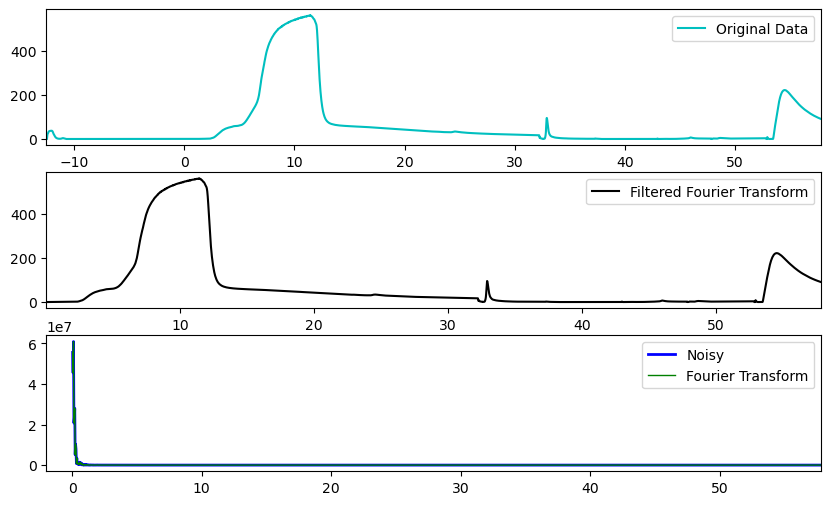

In [157]:
indices = PSD > 0
PSDclean = PSD * indices
fhat = indices * fhat
ffilt = np.fft.ifft(fhat)

fig, axs = plt.subplots(3, 1, figsize=(10,6))
plt.sca(axs[0])
plt.plot(x, data['mAU'].dropna(), color='c', label='Original Data', linewidth=1.5)
# plt.plot(data['ml'], data['mAU'][peaks], "x", color='r', label='Peaks')
plt.xlim(x.values[0], x.values[-1])
plt.legend()


plt.sca(axs[1])
plt.plot(x, ffilt, color='k', label='Filtered Fourier Transform', linewidth=1.5)
plt.xlim(freq[L[0]], x.values[-1])
plt.legend()

plt.sca(axs[2])
plt.plot(freq[L], PSD[L], color='b', label='Noisy', linewidth=2)
plt.plot(freq[L], PSDclean[L], color='g', label='Fourier Transform', linewidth=1)
plt.xlim(-2, x.values[-1])
plt.legend()


In [158]:
peaks

array([  211,  9922, 10583, 16389, 20067, 29613])

/home/kelidan/miniconda3/envs/rdstuff/lib/python3.10/site-packages/scipy/signal/_peak_finding.py:261: ComplexWarning: Casting complex values to real discards the imaginary part
  value = np.asarray(value, order='C', dtype=np.float64)


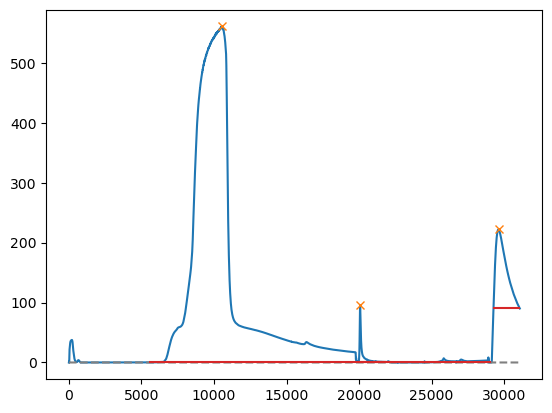

In [159]:
peaks, info = find_peaks(ffilt, height=50, width=80, distance=4000)
results_half = peak_widths(ffilt, peaks, rel_height=0.5)
results_full = peak_widths(ffilt, peaks, rel_height=1)
# sgf = savgol_filter(data['mAU'][peaks], 4, 1)
# plt.plot(peaks, sgf, c = 'orange', linewidth=3)
plt.plot(ffilt)
plt.plot(peaks, ffilt[peaks], "x")
plt.plot(np.zeros_like(ffilt), "--", color="gray")
# plt.hlines(*results_half[1:], color="C2")
plt.hlines(*results_full[1:], color="C3")
plt.show()

In [15]:
mean, std = norm.fit(data['mAU'].dropna())

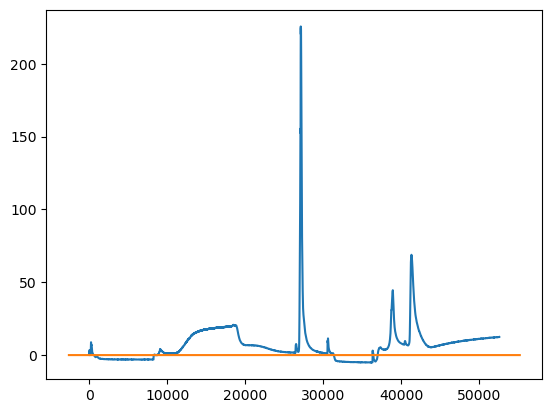

In [71]:
plt.plot(data['mAU'].dropna())
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
y = norm.pdf(x, mean, std)
plt.plot(x, y)
plt.show()

In [137]:
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean) / 4 / stddev)**2)


y = data['mAU'].dropna()
x = data['ml'][:len(y)]

popt, _ = optimize.curve_fit(gaussian, x, y)

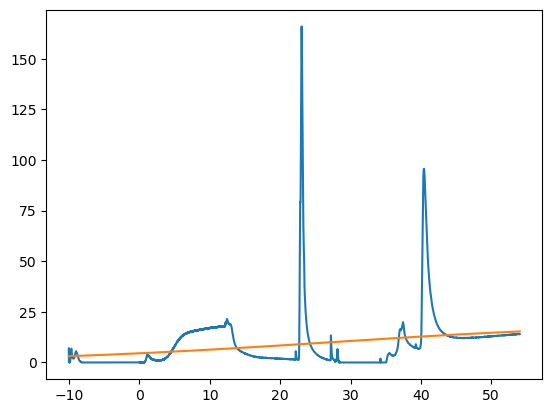

In [138]:
plt.plot(x, y)
plt.plot(x, gaussian(x, *popt))

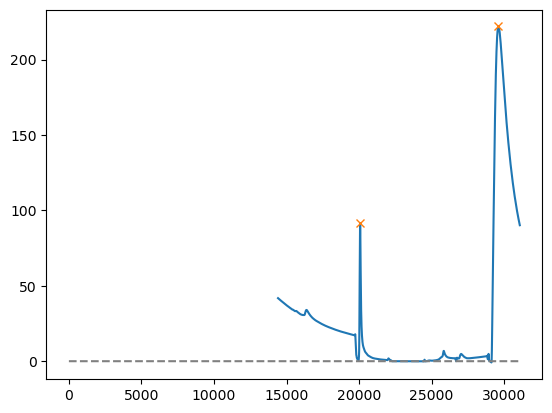

In [16]:
sgf = savgol_filter(data['mAU'], 100, 3)
# plt.plot(sgf, c = 'orange', linewidth=3)

peaks, info = find_peaks(sgf, height=50, width=50)

plt.plot(sgf)
plt.plot(peaks, sgf[peaks], "x")
plt.plot(np.zeros_like(sgf), "--", color="gray")
plt.show()